In [1]:
%%capture
# DO NOT EDIT THIS NOTEBOOK
# It generates a report to verify your submission
import logging, sys, os
logging.disable(sys.maxsize)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import solution
import time
start_verify = time.time()
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,3)

In [2]:
%matplotlib inline
import os
import pickle
import pandas as pd
import numpy as np
import pydot
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import inspect
from IPython.core import page
page.page = print

grades = []

def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')
        
def printSource(obj):
    print(''.join(str(x) for x in inspect.getsourcelines(obj)[0]))
        
# Helper function to extract min/max from the learning curves
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

def print_answer(ans):
    output = ""
    for line in ans.splitlines()[1:]:
        output += line.strip() + " "
    output += "(length: "+str(len(output))+")\n"
    print(output)
        
def run_evaluation(name, model_builder, data, base_dir, target_dir, train=True, 
                   generator=False, epochs=3, batch_size=32, steps_per_epoch=60, 
                   verbose=1, print_model=True, **kwargs):
    """ Trains and evaluates the given model on the predefined train and test splits,
    stores the trained model and learning curves. Also prints out a summary of the 
    model and plots the learning curves.
    Keyword arguments:
    name -- the name of the model to be stored, e.g. 'question_1_1.h5'
    model_builder -- function that returns an (untrained) model. The model must 
                     have a 'fit' function that follows the Keras API. It can wrap
                     a non-Keras model as long as the 'fit' function takes the 
                     same attributes and returns the learning curves (history).
                     It also must have a 'summary' function that prints out a 
                     model summary, and a 'save' function that saves the model 
                     to disk. 
    data -- data split for evaluation. A tuple of either:
            * Numpy arrays (X_train, X_val, y_train, y_val)
            * A data generator and validation data (generator, X_val, y_val)
    base_dir -- the directory to save or read models to/from
    train -- whether or not the data should be trained. If False, the trained model
             will be loaded from disk.
    generator -- whether the data in given as a generator or not
    epochs -- the number of epochs to train for
    batch_size -- the batch size to train with
    steps_per_epoch -- steps per epoch, in case a generator is used (ignored otherwise)
    verbose -- verbosity level, 0: silent, 1: minimal,...
    kwargs -- keyword arguments that should be passed to model_builder.
              Not required, but may help you to adjust its behavior
    """
    model = model_builder(**kwargs)
    if not model:
        shout("No model is returned by the model_builder")
        grades.append("0")
        return
    if not hasattr(model, 'fit'):
        shout("Model is not built correctly")
        return
    learning_curves = {}
    if train and not stop_training: # Train anew
        shout("Model not trained? Skipping.", verbose)
    else: # Load from file
        model = solution.load_model_from_file(base_dir, name)
        if not model:
            shout("Model not found")
            return
        learning_curves = None
        try:
            learning_curves = pickle.load(open(os.path.join(base_dir, name+'.p'), "rb"))
        except FileNotFoundError:
            shout("Learning curves not found")
            return
    # Report
    lc = pd.DataFrame(learning_curves)
    print("Max val score: {:.2f}%".format(lc.iloc[:,3].max()*100))
    grades.append("{:.2f}".format(lc.iloc[:,3].max()*100))
    lc.plot(lw=2,style=['b:','r:','b-','r-']);
    plt.xlabel('epochs');
    plt.show()
    
    if print_model:
        print(model.summary())
    plot_model(model, to_file=os.path.join(target_dir,name+'.png'), show_shapes=True, show_layer_names=False)
        
import pprint
pp = pprint.PrettyPrinter(indent=4)

### Web Information Retrieval and Data Mining - Assignment 3

In [3]:
grades.append(solution.target_dir.split(os.sep)[-1])
grades.append(solution.your_name)
print("Student: {0} ({1})".format(solution.your_name,solution.student_id))

Student: Schilders, Lars (0908729)


#### Answer 1.1, Baseline (4p)
- Dense network, at least 3 layers, shaped like a pyramid
    - Last layer: 10 nodes, sigmoid. 
    - Loss: categorical cross-entropy. Metric: accuracy
- No preprocessing, regularization. Get at least 70% accuracy.
- Explain design decisions. Discuss performance.
    - Does it overfit (large/growing gap between loss and val_loss)?

I start with 1024 nodes and halve that amount in the next two layers. More layers were not better. I used relu as activation over sigmoid, which resulted in no learning. I used 10 output nodes with softmax to get a probability for every class prediction. SGD worked better than rmsprop and Adadelta as optimizer. Categorical cross-entropy is used as loss function to get multi-class predictions.  (length: 397)



Max val score: 84.55%


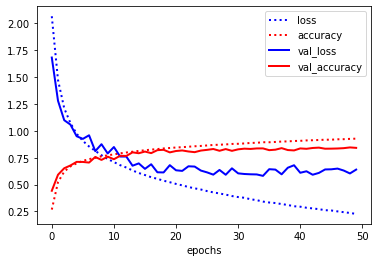

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 3072)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 1024)              3146752   
_________________________________________________________________
dense_17 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_18 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_19 (Dense)             (None, 32)                8224      
_________________________________________________________________
dense_20 (Dense)             (None, 10)                330       
Total params: 3,811,434
Trainable params: 3,811,434
Non-trainable params: 0
____________________________________________

def build_model_1_1():
    model = models.Sequential()
    model.add(layers.Reshape((3072,), input_shape=(32,32,3)))
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer='sgd',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



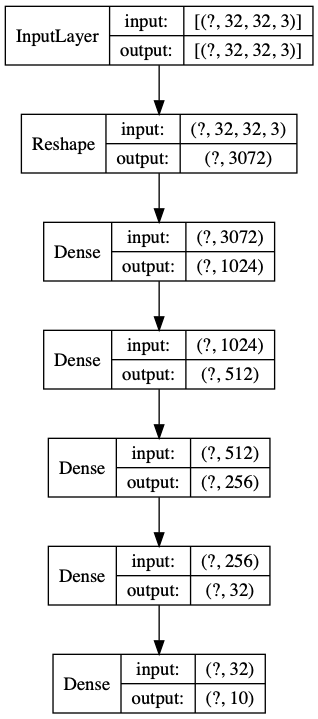

In [4]:
print_answer(solution.answer_q_1_1)
run_evaluation("model_1_1", solution.build_model_1_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_1_1
if os.path.exists(os.path.join(solution.target_dir,'model_1_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_1_1.png'), width=200))

#### Answer 1.2, Preprocess (2p)
- Convert images to greyscale, other preprocessing optional.
    - Input shape should be (32,32,1)
- Explain design decisions. Is it better? Why (not)? 
    - Color information is likely not so useful for classification. Greyscale makes the network smaller, less parameters to learn, less likely to overfit.

By converting X_train and X_val to grey scale the model only slightly improved. It did improve run time as the dimension of the data is reduced by having only 1 color channel instead of 3. The loss curve is slightly improved, as the model now regularizes better because of the dimensionality reduction.  (length: 304)



Max val score: 85.30%


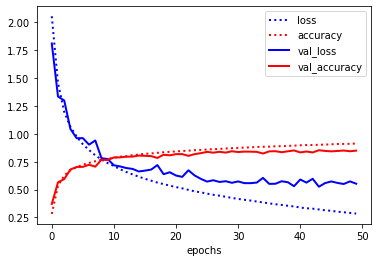

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_6 (Reshape)          (None, 1024)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_25 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_26 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_27 (Dense)             (None, 10)                2570      
Total params: 1,708,298
Trainable params: 1,708,298
Non-trainable params: 0
_________________________________________________________________
None


def build_model_1_2():
    model = models.Sequential()
    model.add(layers.Reshape((32*32,), input_shape=(32,32,1)))
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer='sgd',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



In [5]:
print_answer(solution.answer_q_1_2)
run_evaluation("model_1_2", solution.build_model_1_2, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_1_2

#### Answer 1.3, Tune (4p)
- Regularize the model. What works best? 
    - Should consider batch normalization, dropout, l1/l2 regularization (or Nesterov)
- Tune other hyperparameters (e.g. learning rate, batch size,...) as you see fit.
    - At least consider tuning learning rate, ideally also momentum, decay, other optimizers 
- Explain your findings and final design decisions. Discuss the results.
    - Should be better, at least it shouldn't overfit

I varied the learning rate and the batch size, where batchsize=64 and learning rate=0.05 sped up the training and worked as well as the default values. L1 and L2 regularizers did not improve the model. Constant dropout after every layer regularized better. Batch Normalization resulted in no improvement. The model is regularized well, as the accuracy curves almost completely overlap.  (length: 387)



Max val score: 85.81%


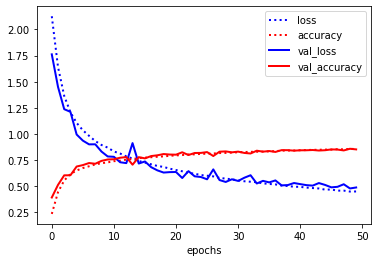

def build_model_1_3():
    model = models.Sequential()
    model.add(layers.Reshape((32*32,), input_shape=(32,32,1)))
    model.add(layers.Dense(1024,  activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(512,   activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(256,   activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer=optimizers.SGD(learning_rate=0.05),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



In [6]:
print_answer(solution.answer_q_1_3)
run_evaluation("model_1_3", solution.build_model_1_3, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False, print_model=False)
%psource solution.build_model_1_3

#### Answer 2.1, ConvNet (7p)
- Build a sequential ConvNet, get at least 90% accuracy.
    - Conv2D layers, input shape (32,32,1)
    - Consider using blocks of Conv2D layers with maxpooling in between
    - Use zero-padding in Conv2D layers because the images are small
    - At least one dense hidden layer and dense output layer (sigmoid)
    - Consider adding batch normalization, dropout
    - Consider small dropout rates in beginning, larger dropout rates later in network
    - Consider other optimizers and tuning learning rate, momentum,...
- Explain what you did and why (800 chars). Is it working well?
    - Should be quite elaborate and sensible

I use 4 blocks with 2 convolutional layers, 2x2 MaxPooling and 20% Dropout each, starting with 32 3x3 filters and double the filters every block, because 2x2 pooling halves the resolution in every dimension. Starting with 64 filters only resulted in a longer computation time. Increasing dropout every time had worse results. Zero padding is used to not lose information at the border of the pictures. As output layer a fully connected layer with 128 nodes and again softmax activated with 10 nodes. RMSProp was a much better optimizer compared to SGD, Adadelta and Adam. Train and test accuracy almost completely overlap, implying good regularization  (length: 653)



Max val score: 95.03%


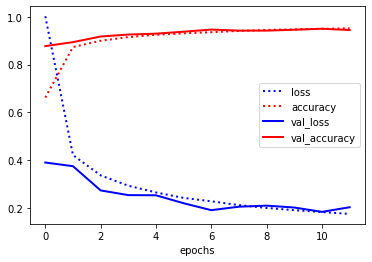

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_98 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_54 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 8, 8, 64)        

def build_model_2_1():
    model = models.Sequential()

    model.add(layers.Conv2D(32,(3,3), activation='relu', padding='same', input_shape=(32,32,1)))
    model.add(layers.Conv2D(32,(3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(64,(3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(64,(3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(128,(3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128,(3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(256,(3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256,(3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.2))

    model.add

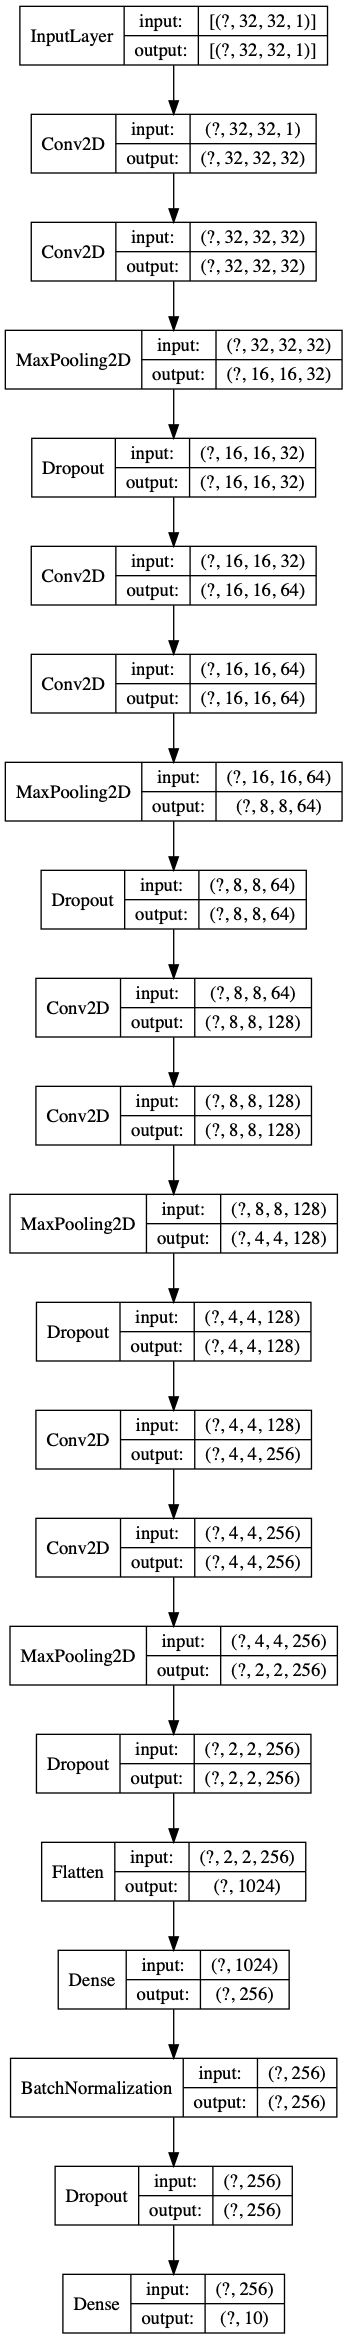

In [7]:
print_answer(solution.answer_q_2_1)
run_evaluation("model_2_1", solution.build_model_2_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_2_1
if os.path.exists(os.path.join(solution.target_dir,'model_2_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_2_1.png'), width=200))

#### Answer 2.2, Data Augmentation (3p)
- Augment the preprocessed training data.
    - Use small variations (small shifts up-down, left-right) of flips becasue the images are small
    - Large shifts and rotations distort the image too much
- Explain what you did and why. Discuss the performance of the model.

Horizontal and vertical flip would not make sense, as mirrored numbers could look like other numbers (6 and 9 for example). The images were nicely centered already, such that larger values of height and width shift do not work well. The model did not improve significantly (only 0.4%) Steps per epoch is put on number of samples divided by the batchsize.  (length: 356)



Max val score: 95.45%


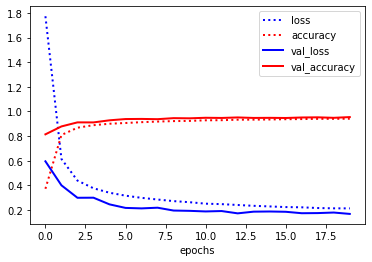


train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range = 5,
    rotation_range = 5,
    zoom_range = [0.95,1.05],
    horizontal_flip = False,
    vertical_flip = False)


In [8]:
print_answer(solution.answer_q_2_2)
run_evaluation("model_2_2", solution.build_model_2_1, solution.augmented_split, solution.base_dir, 
               solution.target_dir, train=False, print_model=False)
print(solution.dg_code)

#### Answer 3.1, Misclassifications (2p)
- Report the test score (on the held-out test data)
    - Should be similar to score of previous model
- Plot confusion matrix, discuss which classes are often confused.
    - class 1 and 2 are most often confused
- Visualize the misclassifications in more depth by focusing on a single class
- Analyse which kinds of mistakes are made for that class.
    - Should contain some insight (e.g. misclassifications when the numbers are curly or noisy)

0 is the prediction that is wrong most times, while 4, 5 and 7 are labels that are most often wrongly predicted. The most common confusion is label 4 while predicting a 2. Looking at the misclassifications, some labels of the test set are wrong, while the model predicted them correct. This means that the real accuracy could be even higher. Images with skewed or multiple numbers seem harder to predict  (length: 405)

Test score: 0.96%


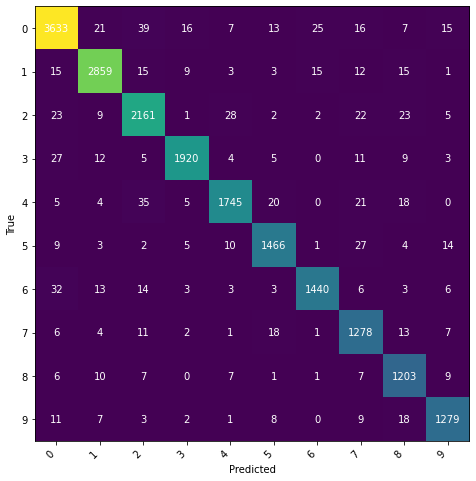

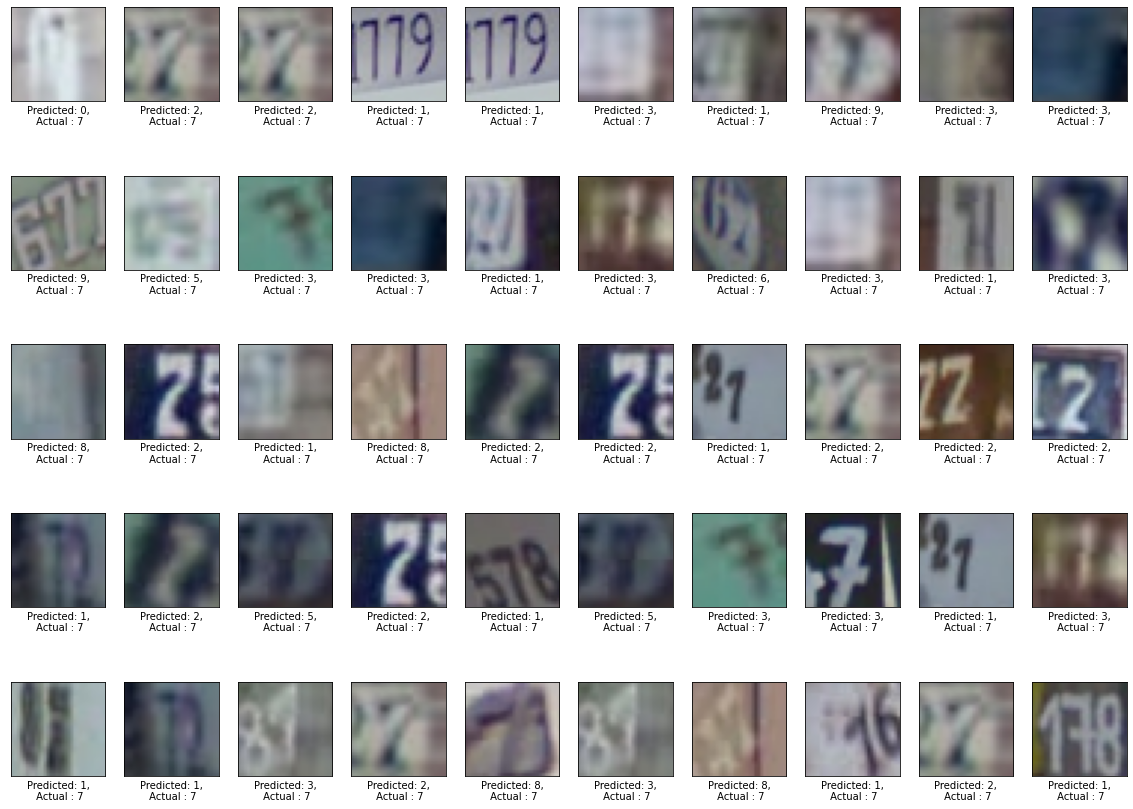

In [9]:
print_answer(solution.answer_q_3_1)
if hasattr(solution, 'test_accuracy_3_1'):
    try:
        print("Test score: {:.2f}%".format(solution.test_accuracy_3_1))
    except TypeError:
        print("Test score:",solution.test_accuracy_3_1)
else:
    print("Test score NOT FOUND: test_accuracy_3_1 missing")
try:
    solution.plot_confusion_matrix()
except:
    print("ERROR, could not build confusion matrix. Please check original report")
try:
    solution.plot_misclassifications()
except:
    print("ERROR, could not build misclassification plot. Please check original report")

#### Answer 3.2, Activations (4p)
- Retrieve and visualize the activations for one example
- For every filter for different convolutional layers (at different depths in the network).
- Give an explanation. Is your model indeed learning something useful?
    - Should detect edges etc in first layers, higher-order object (e.g. interesting regions) in deeper layers.

In the first two layers you can see that some filters pay attention to edges or round shapes or some only to background. In the last layer almost every filter responds to a different shape, which indicates that the model is learning something. Some filters have very low activation values which implies that these filters do not respond well to label 8.  (length: 355)



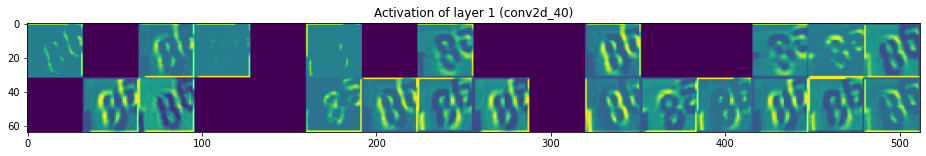

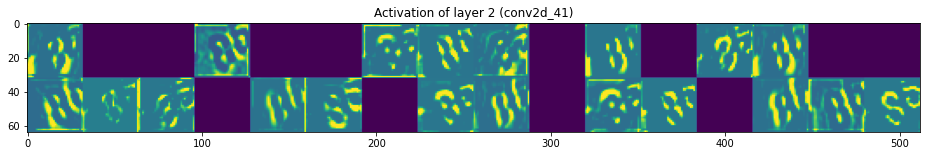

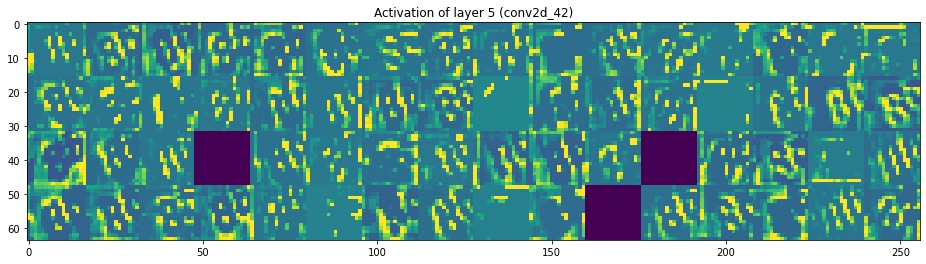

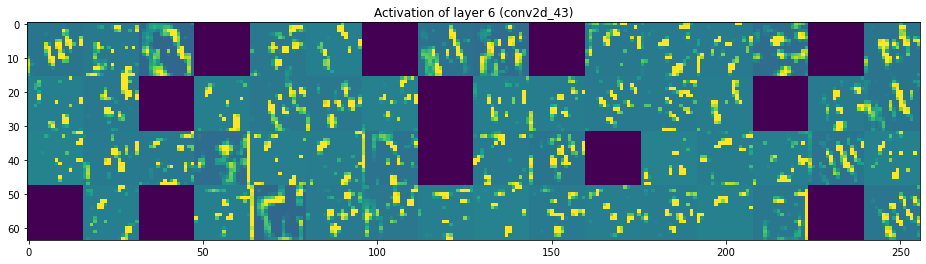

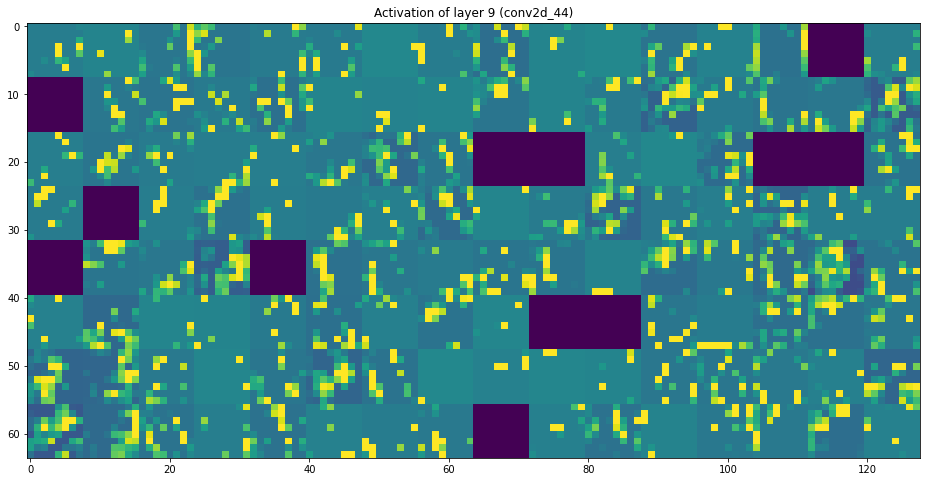

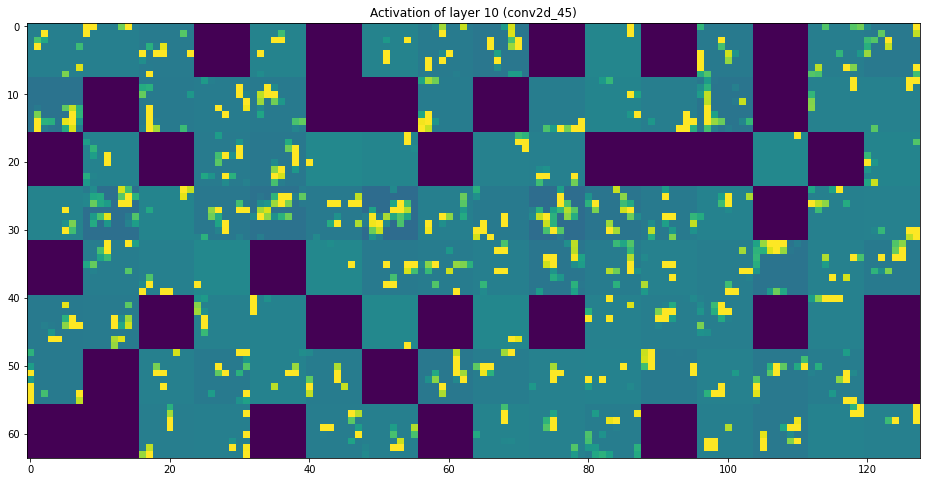

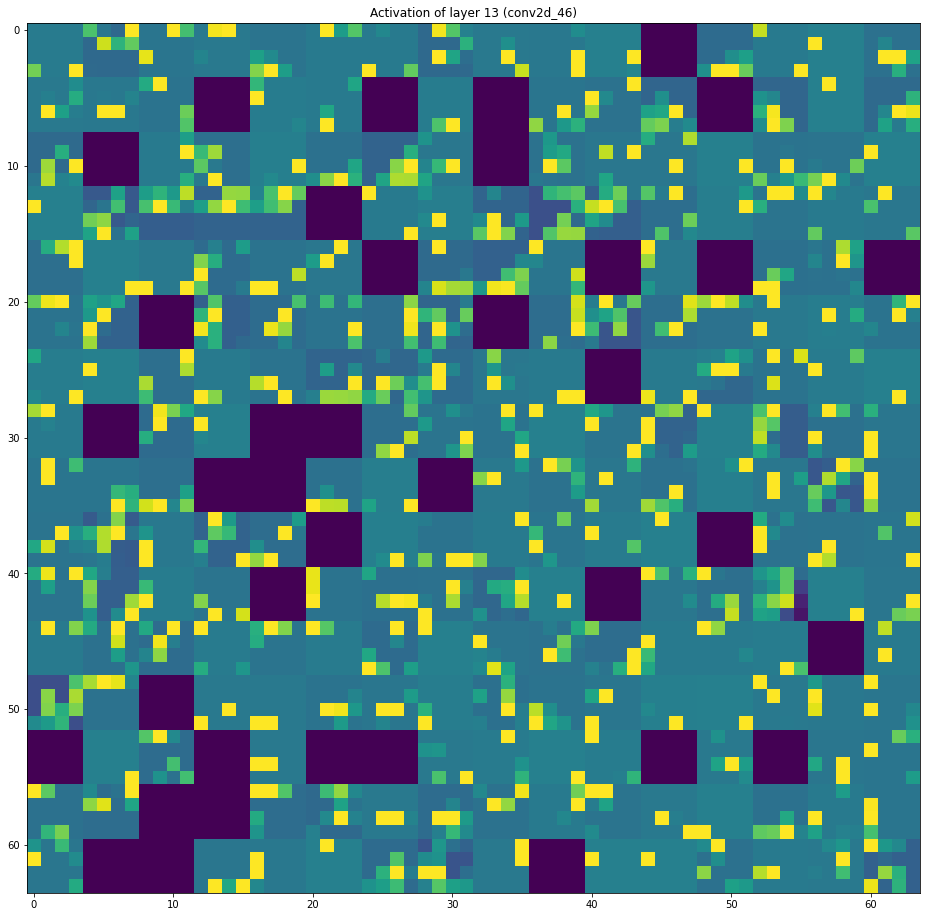

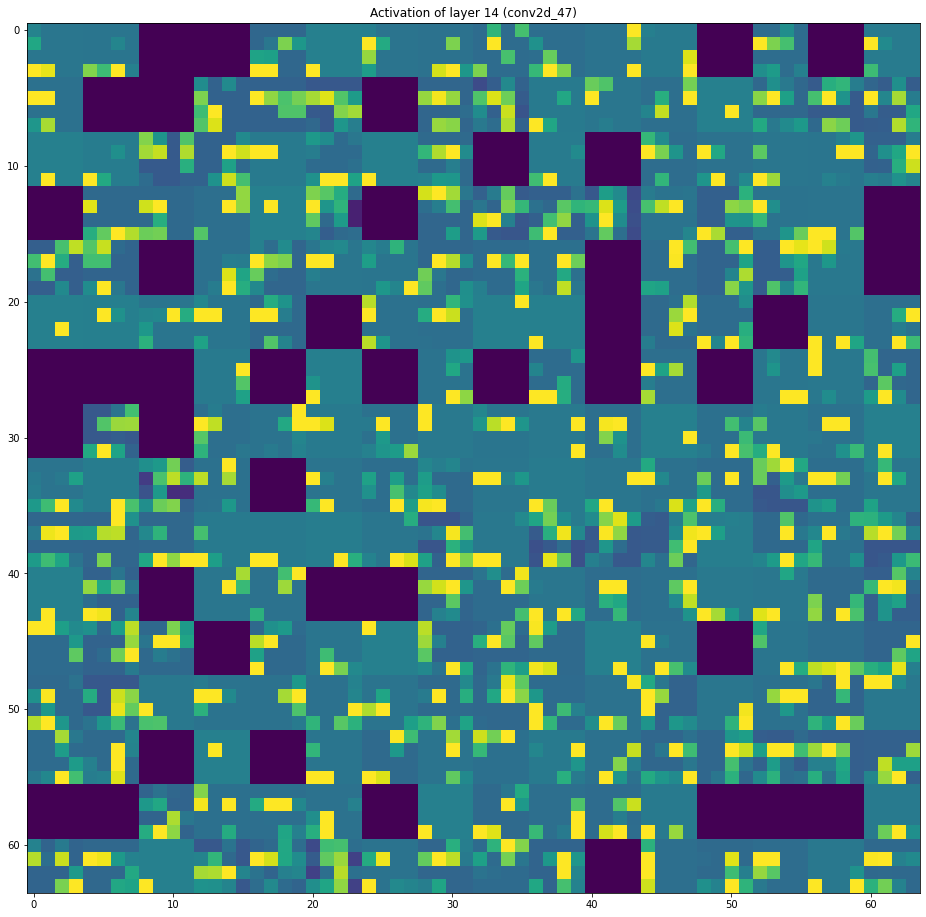

In [10]:
print_answer(solution.answer_q_3_2)
try:
    solution.plot_activations()
except:
    print("ERROR, could not build activation plot. Please check original report")

#### Answer 3.3, Class activation map (4p)
- Show a class activation map for your last convolutional layer
- Superimpose the activation map over the image, or plot side by side
    - Should make sense, detect interesting regions to classify the number

(32, 32)
def plot_3_3():
    tf.compat.v1.disable_eager_execution()
    model = load_model_from_file(base_dir,'model_2_2')
    X_output = model.output[:,0]
    img_tensor = X_test_preprocess[0]
    img_tensor = np.expand_dims(img_tensor, axis=0)

    #retrieve last convolutional layer
    last_conv_layer = model.layers[np.nonzero([lay.name.startswith('conv') for lay in model.layers])[0].max()]

    grads = K.gradients(X_output, last_conv_layer.output)[0]

    pooled_grads = K.mean(grads, axis=(0,1,2))

    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

    pooled_grads_value, conv_layer_output_value = iterate([img_tensor])

    for i in range(32):
        conv_layer_output_value[:,:,i] *= pooled_grads_value[i]

    heatmap = np.mean(conv_layer_output_value, axis=-1)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)


    heatmap = cv2.resize(heatmap, (32, 32))
    heatmap = np.uint8(255 * heatmap)
    print(heatmap.shape)
    heatmap 

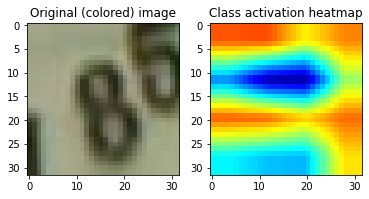

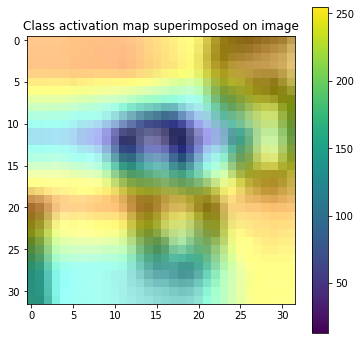

In [11]:
try:
    solution.plot_3_3()
except:
    print("ERROR, could not build class activation plot. Please check original report")
if hasattr(solution, 'plot_activation_map'):
    %psource solution.plot_activation_map
else:
    %psource solution.plot_3_3

#### Answer 4.1, Fast feature extraction (5p)
- Import the VGG16 model, pretrained on ImageNet
- Freeze convolutional base, adds a dense layer
- Consider unfreezing the last few convolutional layers and evaluate whether that works better
    - Check if they do. It is very likely to help.
- Discuss the observed performance
    - Should get around 80% accuracy

Unfreezing last two blocks worked a lot better than freezing the convolutional base. I used a small learning rate of 1e-4, as the model should not overshoot the minimum the pretrained model was in. The loss in the first epoch is very high, implying that the pretrained model is bad, however the accuracy is good. The model still overfits, despite the dropout, batch normalization and L1 regularizer.  (length: 401)



<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x25dcf6828> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x189a1ad30> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x18a4c4da0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x189979dd8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x25f27a208> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x23bca7ef0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x25cd01e80> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x23bce7080> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x25ebd32e8> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x1899a29e8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x25ebc41d0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x25dd162b0> True
<tensorflow.python

Max val score: 92.39%


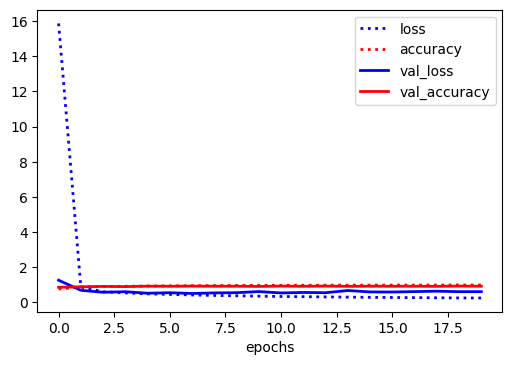

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 256)        

def build_model_4_1():
    model_vgg16 = models.Sequential()
    pretrained_model = vgg16.VGG16(include_top=False, input_shape=(32,32,3))

    for idx, layer in enumerate(pretrained_model.layers):
        if layer.name.startswith('block5_conv') or layer.name.startswith('block4_conv'):
            layer.trainable=True
        else:
            layer.trainable = False
        model_vgg16.add(layer)
    
    model_vgg16.add(layers.BatchNormalization())
    model_vgg16.add(layers.Dropout(0.2))
    model_vgg16.add(layers.Flatten())
    model_vgg16.add(layers.Dense(512, kernel_regularizer = regularizers.l1(), activation='relu'))
    model_vgg16.add(layers.BatchNormalization())
    model_vgg16.add(layers.Dropout(0.2))
    model_vgg16.add(layers.Dense(10, activation='softmax'))
    model_vgg16.compile(optimizer = optimizers.RMSprop(1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    for layer in model_vgg16.layers:
        print(layer, lay

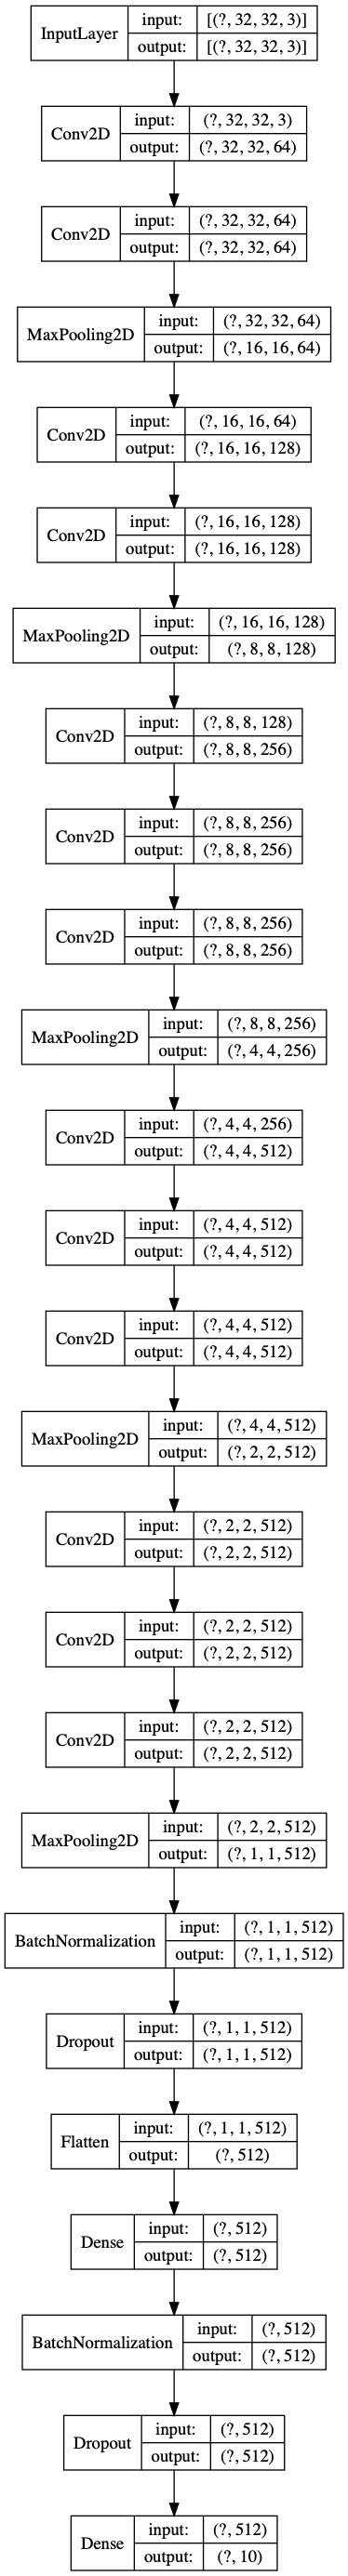

In [12]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

print_answer(solution.answer_q_4_1)
run_evaluation("model_4_1", solution.build_model_4_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_4_1
if os.path.exists(os.path.join(solution.target_dir,'model_4_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_4_1.png'), width=200))
#solution.build_model_4_1().layers[0].summary()

#### Answer 4.2, Embeddings (5p)
- Generate embeddings with the trained convolutional part of model_4_1 (without the dense layer)
- Embed the training and test data and store them to disk
- Build and evaluate a pipeline on the embedded data
    - Check if pipeline makes sense (e.g. use models that can handle many dimensions)
- Describe what you did and what you observed (max 800 chars).
    - Consider different models, preprocessing, tuning, etc.
    - Check performance (see original Submission.html) when in doubt. We did not run all the evaluations because it takes too long, and the output is ill-defined.

In [13]:
print_answer(solution.answer_q_4_2)
print(solution.generate_pipeline())
#print("Evaluation:",solution.evaluation_4_2(solution.X_train, solution.y_train, solution.X_test, solution.y_test))
%psource solution.store_embeddings
%psource solution.evaluation_4_2

I tried a StandardScaler and MinMaxScaler as preprocessors and RandomForest and SVC as classifiers. All combinations gave approximately the same results. I am off of my best model so far by 2%.  (length: 195)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())])
def store_embeddings():
    """ Stores all necessary embeddings to file
    """
    print("Loading model from file")
    model_4_1 = load_model_from_file(base_dir, "model_4_1")
    print("Loaded model from file.")
    conv_base = models.Sequential()
    for layer in model_4_1.layers[:-7]:
        conv_base.add(layer)
    
    conv_base.add(layers.Flatten())
    conv_base.compile(optimizer = 'rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    print("Generating X_test embedding...")
    emb_X_test = conv_base.predict(X_test)
    print("Generating X_train embedding...")
    emb_X_train = conv_base.predict(X_train)

    print("Store X_test embedding...")
    st

In [14]:
end_verify = time.time()
print("Running time: {:.2f} seconds".format(end_verify - start_verify))
print("Last modified: {}".format(solution.last_edit))
print("scikit-learn version: {0}".format(solution.sklearn_version))

with open(solution.grade_file, "a") as myfile:
    myfile.write(','.join(grades)+"\n")

Running time: 15.75 seconds
Last modified: May 26, 2020
scikit-learn version: 0.23.1
